In [1]:
import config
import ast

import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import statistics

from utils.pandas_dataframe import grid_display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from itertools import permutations
import gc

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from morfist import MixedRandomForest

# grid search
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV


from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

from IPython.display import display


%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: '%.2f' % x)
# pd.set_option('display.max_rows', 5)
pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_excel('../Data/2022-train-v2.xlsx')

In [4]:
data_y = data[['sensor_point5_i_value', 'sensor_point6_i_value',\
               'sensor_point7_i_value', 'sensor_point8_i_value',\
               'sensor_point9_i_value', 'sensor_point10_i_value']]
data_x = data.drop(['sensor_point5_i_value', 'sensor_point6_i_value',\
                    'sensor_point7_i_value', 'sensor_point8_i_value',\
                    'sensor_point9_i_value', 'sensor_point10_i_value'], axis=1)

In [5]:
data_x = data_x.fillna(0)

In [6]:
# X變數標準化
scaler = StandardScaler().fit(data_x)
data_x_S = scaler.transform(data_x)

In [7]:
config.grid_search_xgbm.fit(data_x_S, data_y.loc[:,config.Y_variable])
config.grid_search_xgbm.best_params_

{'learning_rate': 0.2,
 'max_depth': 20,
 'min_child_weight': 10,
 'n_estimators': 30,
 'random_state': 1}

In [8]:
model_select = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                         ('std_scaler', StandardScaler()),
                         ('mod', config.model_info['XGB']['Model'])  # 修改model
                        ])

model_select.fit(data_x, data_y.loc[:,config.Y_variable])

y_predict = model_select.predict(data_x)
y_predict

array([ 55.978516,  61.164497,  61.164497,  61.164497,  70.46539 ,
        70.46539 ,  70.46539 ,  70.46539 ,  70.7698  ,  70.7698  ,
        66.48365 ,  66.48365 ,  66.48365 ,  66.48365 ,  69.83103 ,
        69.83103 ,  81.830864,  81.830864,  76.255615,  78.48961 ,
        78.48961 ,  76.03668 ,  77.71033 ,  77.71033 ,  77.71033 ,
        70.35612 ,  74.92504 ,  57.961567,  57.961567,  57.154736,
        57.154736,  57.154736,  57.154736,  53.980415,  54.330505,
        54.330505,  54.330505,  54.330505,  54.330505,  54.330505,
        54.330505,  54.330505,  59.912117,  59.912117,  59.912117,
        50.895832,  50.895832,  50.895832,  62.455055,  49.28136 ,
        54.029835,  54.029835,  47.518963,  49.712708,  49.712708,
        54.89477 ,  54.89477 ,  54.89477 ,  56.332623,  56.332623,
        66.81594 ,  66.81594 ,  77.799835,  74.26175 ,  79.7286  ,
        68.322495,  68.322495,  82.126854,  61.82033 ,  73.596115,
        73.596115,  73.596115,  73.596115,  80.638695,  80.638

In [9]:
k_fold_RMSE = -cross_val_score(model_select, 
                               data_x,
                               data_y.loc[:,config.Y_variable], 
                               cv = 5, 
                               scoring = 'neg_root_mean_squared_error').mean()

print('RMSE:' + str(round(k_fold_RMSE,2)))

RMSE:25.79


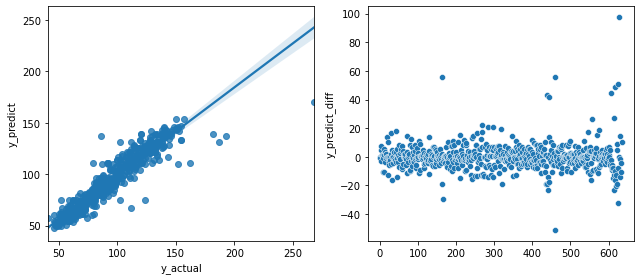

In [10]:
y_predict_diff = data_y.loc[:,config.Y_variable] - y_predict

model_result = pd.DataFrame({'y_predict_diff':y_predict_diff,
                             'y_actual':data_y.loc[:,config.Y_variable],
                             'y_predict':y_predict})
# display(Y_predict_diff)

# seaborn呈現結果
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# 預測值跟實際值分布狀況
sns.regplot(x = 'y_actual', 
            y = 'y_predict',
            data = model_result, 
            ax=axes[0])
    
    # 每筆資料的差異
sns.scatterplot(x = model_result.index,
                y = 'y_predict_diff',
                data = model_result, 
                ax=axes[1])
    
    
plt.tight_layout()